# Time series analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
plt.style.use('fivethirtyeight')

## TODO

Predict electricity usage<br>
set a time feature for linear regression<br>
Are lags predictive?  If so add them<br>
What is your models Rsquared?

In [3]:
df=pd.read_csv('elecdemand.csv',parse_dates=["Datetime"])
df.head()

,Datetime,Demand
0,2000-06-05 00:00:00,44018
1,2000-06-05 01:00:00,45006
2,2000-06-05 02:00:00,44862
3,2000-06-05 03:00:00,43988
4,2000-06-05 04:00:00,43087


In [4]:
df=df.set_index('Datetime')
print(df.shape)
print(df.isnull().sum().sum())
# df.head()
#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))


(2016, 1)
0


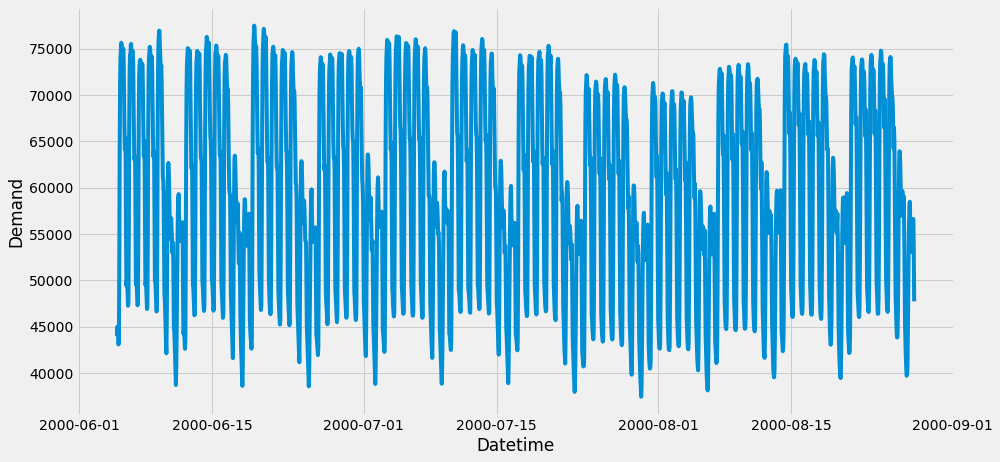

In [5]:
fig,ax=plt.subplots(figsize=(14,7))
_=sns.lineplot(data=df,x=df.index,y='Demand')

# Lags - Are they predictive?

/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


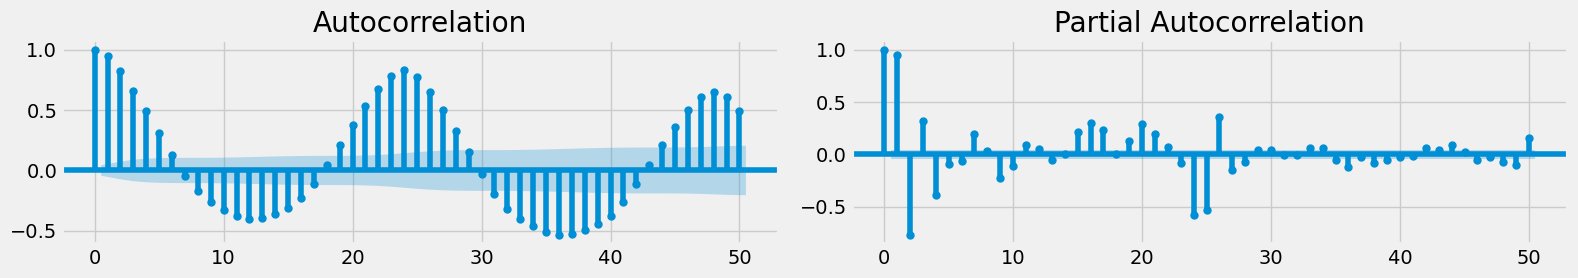

In [6]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.Demand.tolist(), lags=50, ax=axes[0])
plot_pacf(df.Demand.tolist(), lags=50, ax=axes[1])
plt.tight_layout()


## Yes, add them to the dataframe
These plots show that past values are predictive of future values, so add them to the dataset
start with 7

# Feature Engineering

## Do holidays effect electricity demand?

### Create a calander to track local holidays

In [7]:
# create a calander of swiss holidays to mark in the dataset
#see https://sodocumentation.net/pandas/topic/7976/holiday-calendars
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

# want US holidays?  There is a package for that that operates like the custom calendar above
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

In [8]:
#Find all holidays in the tunnel traffic time series
hols=cal.holidays(start=str(df.index[0]), end=str(df.index[len(df)-1]))
hols

DatetimeIndex(['2000-07-04'], dtype='datetime64[ns]', freq=None)

In [9]:
df.isnull().sum()

Demand    0
Time      0
dtype: int64

### Add holidays to dataframe

In [10]:
def add_holidays(df,hols):
    '''
    adds a holiday column to df with a 1 if day is a holiday, 0 otherwise
    returns modified df
    '''
    df['Holiday'] = df.index.isin(hols).astype(int)
    return df
df=add_holidays(df,hols)
# df.head(10)

## It's helpful to know if it's a workday or a weekend, so add a column that indicates that

In [11]:
## maybe mark whether its a workday or a weekend?  This information is probably encoded in the lags already
#is it a workday or weekend
df['wd'] = 1  #its a workday
df.loc[df.index.dayofweek > 4, 'wd'] = 0  # >4 is weekend

In [12]:
df.head()

,Demand,Time,Holiday,wd
Datetime,,,,
2000-06-05 00:00:00,44018,0,0,1
2000-06-05 01:00:00,45006,1,0,1
2000-06-05 02:00:00,44862,2,0,1
2000-06-05 03:00:00,43988,3,0,1
2000-06-05 04:00:00,43087,4,0,1


## Get train test split

In [13]:
from sklearn.model_selection import train_test_split
y=df['Demand']
df=df.drop(columns=['Demand'])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42, shuffle=False)

# The hybrid Model

Predicts travel for the next day based on the current date, previous n lag values and holiday and holiday_travel_day values. 
The model has 2 methods:<br>
fit:
1. Fit a linear regressor (model_1) to a train set
2. Calculate predictions (preds) on train set
3. Calculate residuals (target-preds) to detrend the train set
4. Fit catboost (model_2) on train set residuals 

predict:
1. model_1.predict + model_2.predict

Their are some problems however, the first is the lags, when predicting we have to have a list of n previous residuals. This means that the start of test set will be missing the end of the training sets lag values unless they are saved somehow.<br>
The second problem is that the model_2 depends on the residulas calculated by the first model for the lags. Specifically model_2 works on the detrended data, these have to be calculated and saved, which means the model has to see the test data to calculate the lags.  This is not a problem in terms of leakage, it just makes keeping track of data and ensuring the model does not accidentally 'see' future or current data that much harder.


In [27]:
class BoostedHybrid:
    '''
    Runs model_1 on data, then runs model_2 on residuals of model_1
    In practice model_1 detrends the data then model_2 uses a ML algorithm to forcast target values on detrended data
    '''
    def __init__(self, model_1, model_2, num_lags=0):
        self.model_1 = model_1
        self.model_2 = model_2
        self.num_lags=num_lags

    def fit(self, X_1,X_2, y):
        '''
        X_1 dataset for linear regression(uses column 'Time')
        X_2 dataset for GBT ('all other dataset columns')
        y  target ('NumVehicles')
        '''
        self.train_size=len(X_1)
        
        #fit the first model on train portion of dataset
        self.model_1.fit(X_1, y) # train model 1
        
        #generate residuals for entire dataset (only used to calculate lags)
        self.y_resid = y - self.model_1.predict(X_1)
        
        #compute and add the lags to X_2
        X_2['y_resid']=self.y_resid
        for i in range(1,self.num_lags+1):
            X_2['Lag_'+str(i)]=X_2.y_resid.shift(i)
        X_2.dropna(inplace=True)  #alas goodbye to some rows
        # display(X_2)
        
        #save these residuals for later
        self.y_resid=X_2.y_resid
        
        #drop target from training data
        X_2.drop(columns=['y_resid'],inplace=True, axis=1)  #this gets rid of target value, so model only sees past lags
        # display(X_2)
        
        #fit the second model on residuals from first model, just the train data part
        self.model_2.fit(X_2.iloc[0:self.train_size,:], self.y_resid[:self.train_size])
        self.X_1=X_1
        self.X_2=X_2
        
    def predict(self,X_1,X_2, y):
        #to get a prediction add Model_1's prediction to Model_2's prediction
        #generate residuals for dataset
        X_2['preds'] = self.model_1.predict(X_1)
        X_2['y_resid']=y-X_2['preds'] 
        
        #compute and add the lags to X_2
        for i in range(1,self.num_lags+1):
            X_2['Lag_'+str(i)]=X_2.y_resid.shift(i)

        X_2.dropna(inplace=True)  #alas goodbye to some rows
        # display(X_2)
       
        #get the X_1 preds
        y_pred1 = X_2['preds']
        
        #drop columns that are not used for model_2
        X_2.drop(columns=['preds','y_resid'], inplace=True)
        y_pred2=self.model_2.predict(X_2)
        return(y_pred1+y_pred2)

## Partition dataset

In [28]:
#get our target value, the training set for linear regression, and the training set for catboost
X_1=X_train.loc[:,['Time']]
X_2=X_train.loc[:,['Time','Holiday','wd']]
# display(y)
# display(X_1)
# display(X_2)
# print(y.isna().sum())
# print(X_1.isnull().sum().sum())

## Train the model on train set

In [29]:
from sklearn import linear_model
from catboost import CatBoostRegressor
hm=BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(silent=True, random_state=42), num_lags=0)

#fit the model
hm.fit(X_1,X_2,y_train)

## Get test set predictions and Rsquared

In [30]:

#get our target value, the training set for linear regression, and the training set for catboost
X_1t=X_test.loc[:,['Time']]
X_2t=X_test.loc[:,['Time','Holiday','wd']]
#get predictions on test set
preds=hm.predict(X_1t,X_2t,y_test)
# preds

In [31]:
#It was not clear what objective lightGBM optimizes
#so I implemented R squared below 
def rsquared(preds, y):
    '''
    preds: model predictions
    y: ground truth values
    returns: rsquared for above
    '''
    RSS=np.sum(np.square(preds-y))
    ymean=np.sum(y)/len(y)
    TSS=np.sum(np.square(y-ymean))
    return 1-RSS/TSS

print(f'Rsquared={rsquared(preds, y[-len(preds):] )}')

Rsquared=0.06333819676686525


# Lets plot predictions verses actuals

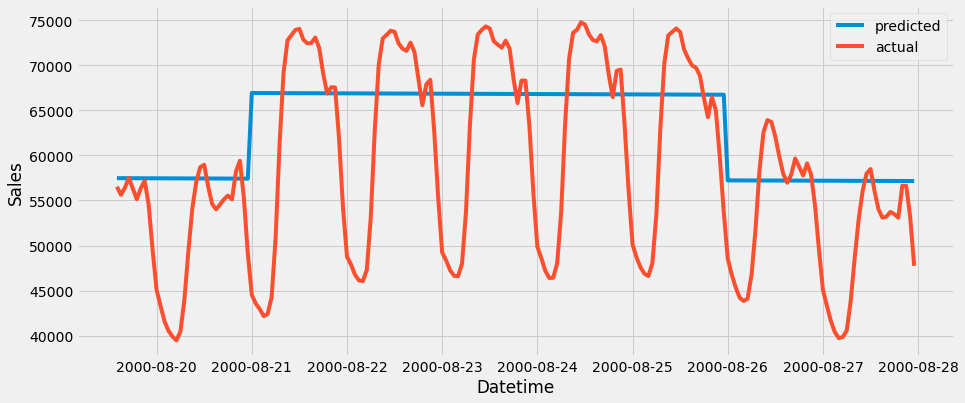

In [32]:
df_preds = pd.DataFrame(index=df.index[-len(preds):])
df_preds['Sales']=preds
df_y=pd.DataFrame(index=df.index[-len(preds):])
df_y['Sales']=y[-len(preds):]

fig, ax1 = plt.subplots(figsize=(14,6))
_=sns.lineplot(data=df_preds, x=df_preds.index, y='Sales',ax=ax1)
_=sns.lineplot(data=df_y, x=df_y.index, y='Sales',ax=ax1)
plt.legend(labels=["predicted","actual"])

# <mark> Permutation Importance 

In [33]:
from sklearn.inspection import permutation_importance

In [34]:
X_2t.columns

Index(['Time', 'Holiday', 'wd'], dtype='object')

In [35]:
%%time
feature_names=X_2t.columns
result = permutation_importance(
    hm.model_2, X_2t, y_test[-len(X_2):], n_repeats=10, random_state=42, n_jobs=2, scoring=None)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 8.79 ms, sys: 4.18 ms, total: 13 ms
Wall time: 41 ms


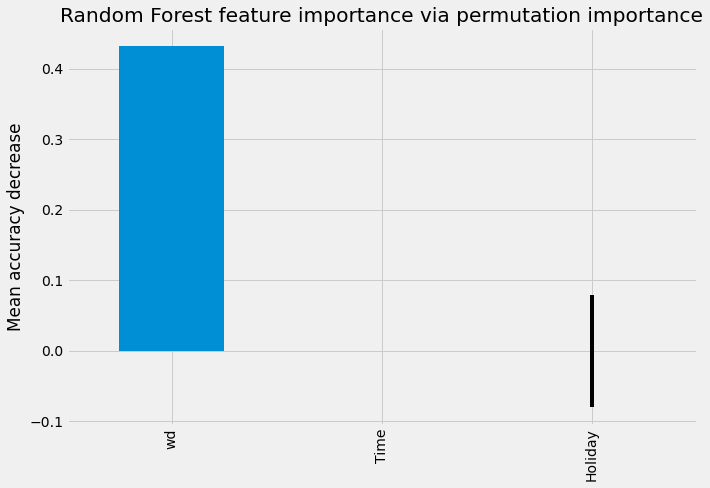

In [36]:
#plot em
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Random Forest feature importance via permutation importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()